In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, regexp_replace, transform, isnan

spark = SparkSession.builder.appName("LightcastCleanedData").getOrCreate()

# 重新加载处理后的数据
df_cleaned = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").csv("data/lightcast_cleaned.csv")

# 查看数据结构和样本
df_cleaned.show()

your 131072x1 screen size is bogus. expect trouble
25/04/19 22:42:40 WARN Utils: Your hostname, DESKTOP-AEE21PF resolves to a loopback address: 127.0.1.1; using 192.168.167.208 instead (on interface eth0)
25/04/19 22:42:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/19 22:42:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/19 22:42:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-------------------+----------------------+----------+----------+----------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+---------+--------------------+--------------------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+------------------+------+--------------------+-----+--------------------+-----+-------------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+-----

In [ ]:
df_cleaned.select("TITLE_RAW").distinct().show(10, False)

30346

In [8]:
from pyspark.sql.functions import col, when
# Create a new column EDU_MATCH, mark it as a match or not
df_compare = df_cleaned.withColumn(
    "EDU_MATCH",
    when(col("ONET") == col("ONET_2019"), "Match").otherwise("Mismatch")
)

df_compare.select("ONET", "ONET_2019", "EDU_MATCH").show(truncate=False)

# 统计不匹配的行数
unmatched_count = df_cleaned.filter(col("MIN_EDULEVELS") != col("EDUCATION_LEVELS")).count()
print(f"Not Match: {unmatched_count}")

+----------+----------+---------+
|ONET      |ONET_2019 |EDU_MATCH|
+----------+----------+---------+
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
+----------+----------+---------+
only showing top 20 rows



Not Match: 0


In [9]:
from pyspark.sql.functions import col, when
# Create a new column EDU_MATCH, mark it as a match or not
df_compare = df_cleaned.withColumn(
    "EDU_MATCH",
    when(col("ONET_NAME") == col("ONET_2019_NAME"), "Match").otherwise("Mismatch")
)

df_compare.select("ONET_NAME", "ONET_2019_NAME", "EDU_MATCH").show(truncate=False)

# 统计不匹配的行数
unmatched_count = df_cleaned.filter(col("MIN_EDULEVELS") != col("EDUCATION_LEVELS")).count()
print(f"Not Match: {unmatched_count}")

+------------------------------+------------------------------+---------+
|ONET_NAME                     |ONET_2019_NAME                |EDU_MATCH|
+------------------------------+------------------------------+---------+
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Busine

Not Match: 0


k = 2, SSE = 1639431.82


k = 3, SSE = 1608367.32


k = 4, SSE = 1583154.79


k = 5, SSE = 1538237.71


k = 6, SSE = 1512579.31


k = 7, SSE = 1499198.45


k = 8, SSE = 1461431.65


k = 9, SSE = 1422329.48


k = 10, SSE = 1416654.36


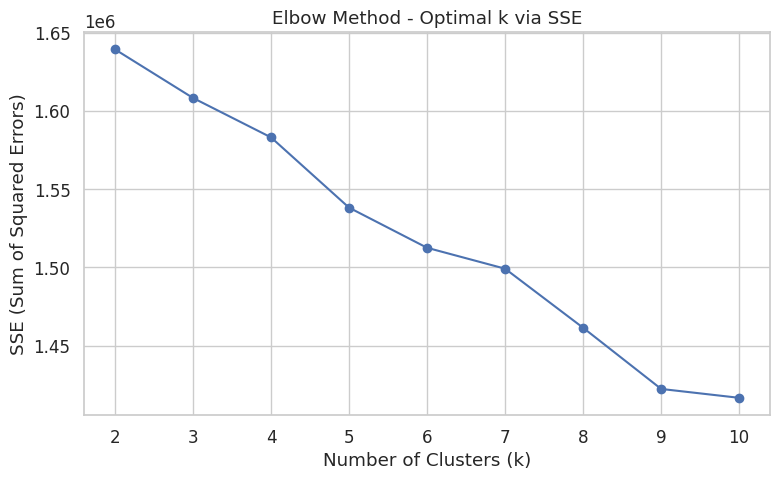

In [67]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

# === 选择用于聚类的字段 ===
numeric_cols = ["DURATION", "SALARY"]
categorical_cols = ["MIN_EDULEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "STATE_NAME"]

df_kmeans = df_cleaned.select(numeric_cols + categorical_cols).dropna()

# === 类型转换 ===
for col_name in numeric_cols:
    df_kmeans = df_kmeans.withColumn(col_name, col(col_name).cast(DoubleType()))

# === 处理分类变量 ===
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid='skip') for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec") for c in categorical_cols]
encoded_categorical = [f"{c}_vec" for c in categorical_cols]

# === 特征组合 ===
assembler = VectorAssembler(
    inputCols=numeric_cols + encoded_categorical,
    outputCol="raw_features"
)

# === 标准化 ===
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)

# === 遍历不同 k 值，计算 SSE ===
cost = []  # 用于存储 k 和对应的 SSE 值
for k in range(2, 11):  # k 从 2 到 10
    kmeans = KMeans(k=k, seed=688, featuresCol="features")
    pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, kmeans])
    
    # 拟合模型
    model_kmeans = pipeline.fit(df_kmeans)
    
    # 获取 KMeans 聚类模型阶段（Pipeline 的最后一个 stage）
    kmeans_data = model_kmeans.stages[-1]
    sse = kmeans_data.summary.trainingCost  # 获取 SSE 值
    cost.append((k, sse))  # 存储 k 和 SSE
    print(f"k = {k}, SSE = {sse:.2f}")

# === 绘制 Elbow 图 ===
k_vals, sse_vals = zip(*cost)  # 解包 k 和 SSE
plt.figure(figsize=(8, 5))
plt.plot(k_vals, sse_vals, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Method - Optimal k via SSE")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/elbow.png", dpi=300, bbox_inches='tight')
plt.show()


In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

k = 3 # 你可以根据 Elbow 图选择最优 k
kmeans = KMeans(k=k, seed=688, featuresCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, kmeans])
model_kmeans = pipeline.fit(df_kmeans)

# 获取聚类结果并保留 EMPLOYMENT_TYPE_NAME 和 prediction（聚类标签）
clustered_df = model_kmeans.transform(df_kmeans).select("EMPLOYMENT_TYPE_NAME", "prediction")

# === 转换为 Pandas，用于 sklearn 评估 ===
pandas_df = clustered_df.toPandas()

# 标签编码
le = LabelEncoder()
true_labels = le.fit_transform(pandas_df["EMPLOYMENT_TYPE_NAME"])
predicted_labels = pandas_df["prediction"]

# 把cluster重新插入回df_kmeans
df_kmeans = model_kmeans.transform(df_kmeans) \
                   .withColumnRenamed("prediction", "cluster")

# 计算评估指标
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
ari = adjusted_rand_score(true_labels, predicted_labels)


print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")



NMI: 0.0010
ARI: -0.0170


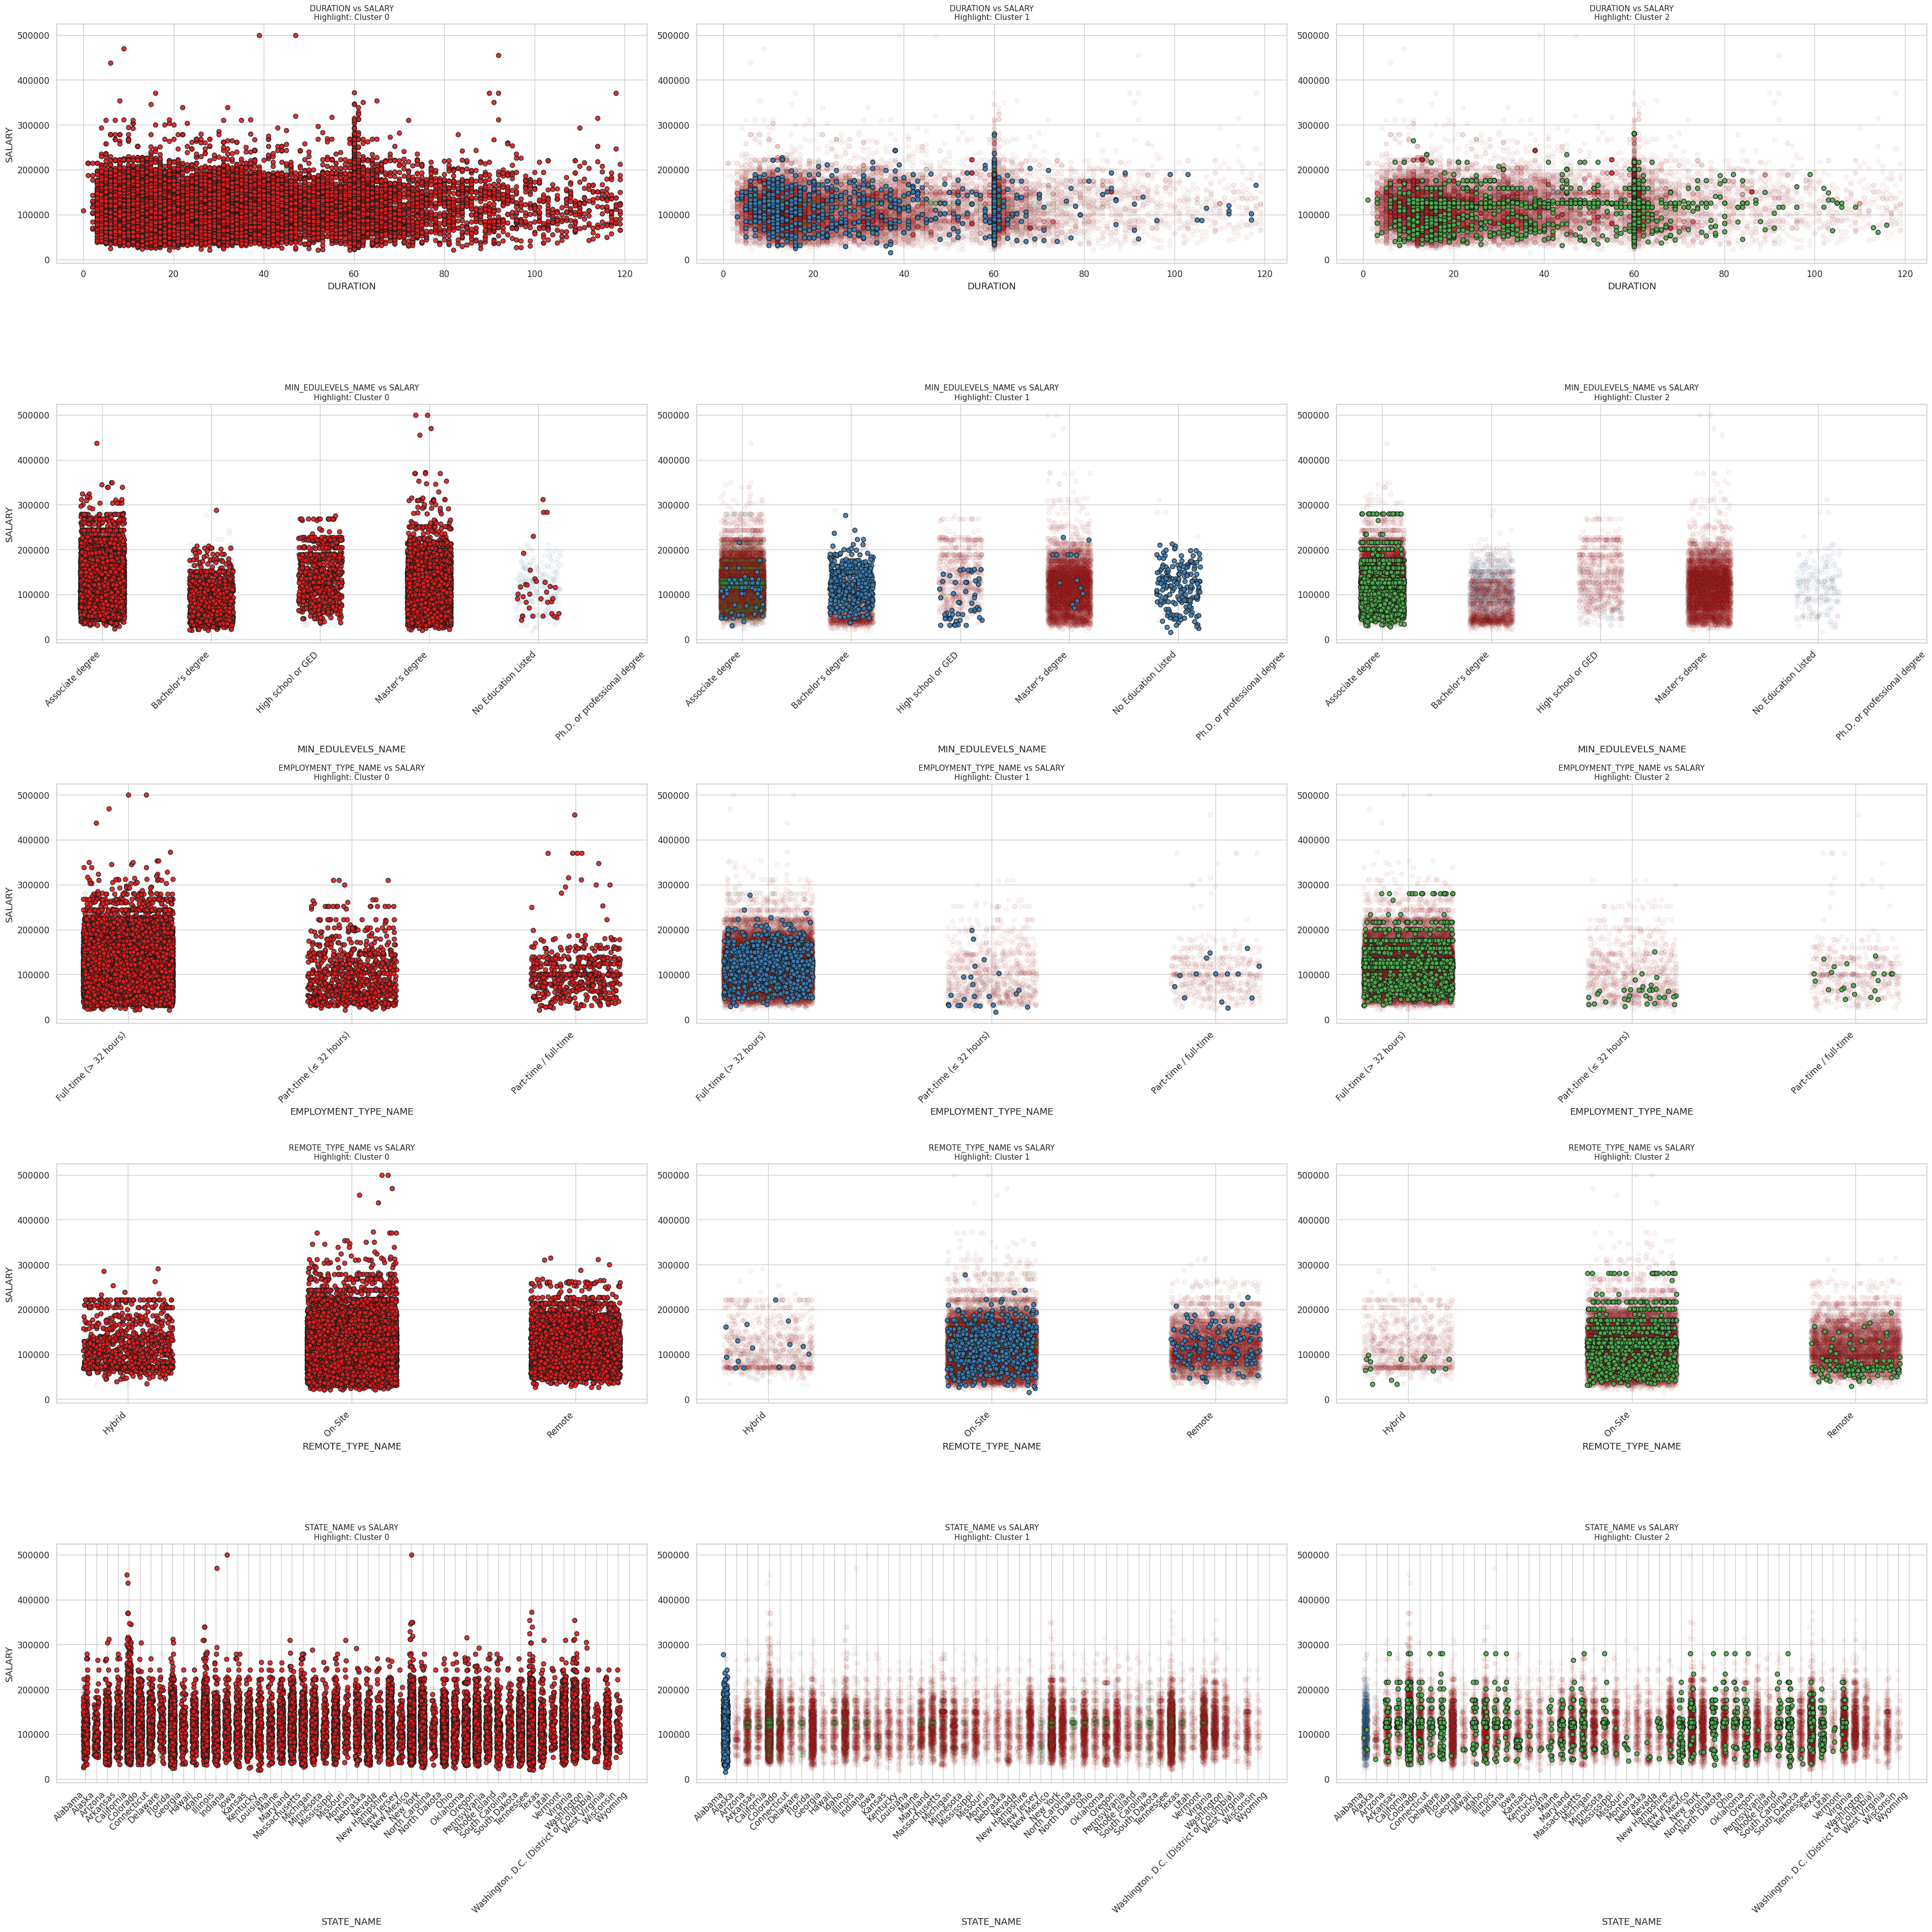

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 准备数据
pandas_df = df_kmeans.select(
    "DURATION", "SALARY", "MIN_EDULEVELS_NAME", 
    "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "STATE_NAME", "cluster"
).toPandas()

# 设置变量和 cluster ID
vars_to_plot = ["DURATION", "MIN_EDULEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "STATE_NAME"]
highlight_clusters = [0, 1, 2]  # 每行展示这三个 cluster 的高亮效果
num_clusters = pandas_df["cluster"].nunique()

# 设置对比色
palette = sns.color_palette("Set1", n_colors=num_clusters)
color_map = {cid: palette[cid] for cid in range(num_clusters)}

# jitter 函数
def jitter(arr, strength=0.2):
    return arr + np.random.uniform(-strength, strength, size=arr.shape)

# 创建图
fig, axes = plt.subplots(len(vars_to_plot), len(highlight_clusters), figsize=(38, 38)) # 加大图像大小防止重叠
axes = axes.reshape(len(vars_to_plot), len(highlight_clusters))

for row_idx, var in enumerate(vars_to_plot):
    is_numeric = np.issubdtype(pandas_df[var].dtype, np.number)

    # 如果是类别变量，提前准备映射
    if not is_numeric:
        cat_series = pandas_df[var].astype("category")
        categories = dict(enumerate(cat_series.cat.categories))
    
    for col_idx, highlight_cid in enumerate(highlight_clusters):
        ax = axes[row_idx, col_idx]
        for cid in range(num_clusters):
            subset = pandas_df[pandas_df["cluster"] == cid]
            x = subset[var] if is_numeric else jitter(subset[var].astype("category").cat.codes) # 将类别变量（如 EMPLOYMENT_TYPE_NAME）转换为 category 类型。 然后通过 .cat.codes 将每个类别值映射为一个唯一的整数代码（例如，"Full-time" 可以被映射为 0，"Part-time" 映射为 1 等）。 这一步将类别变量从字符串转换为数值，方便在散点图中进行绘制。
            y = subset["SALARY"]
            alpha = 0.05 if cid != highlight_cid else 0.9
            zorder = 2 if cid == highlight_cid else 1
            ax.scatter(x, y, color=color_map[cid], alpha=alpha, edgecolor='k', s=40, zorder=zorder)

        ax.set_title(f"{var} vs SALARY\nHighlight: Cluster {highlight_cid}", fontsize=11)
        ax.set_xlabel(var)
        if col_idx == 0:
            ax.set_ylabel("SALARY")
        else:
            ax.set_ylabel("")

        # 设置 x 轴标签为类别名
        if not is_numeric:
            ax.set_xticks(list(categories.keys()))
            ax.set_xticklabels(list(categories.values()), rotation=45, ha='right')

# 整体布局
plt.tight_layout()
plt.savefig("images/kmeans.png", dpi=300, bbox_inches='tight')
plt.show()


In [3]:
# ===== 多元线性回归（标准化版本）=====
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType

# 选择字段
lr_df = df_cleaned.select(
    "DURATION", "EDUCATION_LEVELS", "SALARY", "SALARY_FROM", "SALARY_TO"
).dropna()

# 类型转换
num_cols = ["DURATION", "EDUCATION_LEVELS", "SALARY", "SALARY_FROM", "SALARY_TO"]
for col_name in num_cols:
    lr_df = lr_df.withColumn(col_name, col(col_name).cast(DoubleType()))

# 拼接特征向量
assembler = VectorAssembler(
    inputCols=["DURATION", "EDUCATION_LEVELS", "SALARY_FROM", "SALARY_TO"],
    outputCol="assembled_features"
)

# 标准化
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

# 模型
lr = LinearRegression(featuresCol="features", labelCol="SALARY")

# 划分训练测试集
train_data, test_data = lr_df.randomSplit([0.8, 0.2], seed=42)
train_data = train_data.na.drop(subset=num_cols)
test_data = test_data.na.drop(subset=num_cols)

pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# 评估
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

print("\n✅ 多元线性回归结果:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


25/04/19 20:42:57 WARN Instrumentation: [c0826b6d] regParam is zero, which might cause numerical instability and overfitting.



✅ 多元线性回归结果:
R²: 0.9991
RMSE: 1340.99
